# Import Dependencies

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import deepgraph as dg
from mpl_toolkits.basemap import Basemap

%matplotlib inline

plt.style.use("ggplot")

# Selecting Data From the Database

In [2]:
# Create the connection with the database
connection = psycopg2.connect(dbname='geocenter',
                              user='vcchow', 
                              host='cslvm74.csc.calpoly.edu', 
                              password='vcchow')

cur = connection.cursor()
 
query = """
SELECT
    A.id,
    A.version,
    A.author,
    B.id,
    B.version,
    B.author,
    ST_X(A.point),
    ST_Y(A.point),
    ST_X(B.point),
    ST_Y(B.point),
    ST_Distance(A.point, B.point) AS dist
  FROM (SELECT
          C.id,
          C.version,
          C.point,
          D.timestamp,
          D.author
        FROM (node C
          JOIN osm_entity D ON C.id = D.id AND C.version = D.version)
        WHERE author != 'bigalxyz123' AND extract(YEAR FROM D.timestamp) >= 2017) A
    JOIN (SELECT
            N.id,
            N.version,
            N.point,
            O.author
          FROM (node N
            JOIN osm_entity O ON N.id = O.id AND N.version = O.version)
          WHERE extract(YEAR FROM O.timestamp) >= 2017 AND author != 'bigalxyz123') B
      ON ST_DWithin(A.point, B.point, 1)
  WHERE A.id != B.id
  LIMIT 500000;
"""
cur.execute(query)
queried_data = cur.fetchall()

# Creating the Deep Graph

In [4]:
# Load the data into a pandas dataframe
youth_data = pd.DataFrame(queried_data, columns = ["A_id", "A_version", "A_author", "B_id", 
                                                   "B_version", "B_author","A_lat", "A_lon", 
                                                   "B_lat", "B_lon", "Distance"])

In [5]:
youth_data.head()

,A_id,A_version,A_author,B_id,B_version,B_author,A_lat,A_lon,B_lat,B_lon,Distance
0,2291977128,2,Glucosamine,138010360,9,kreuzschnabel,54.373457,-0.84365,54.787526,-1.736979,0.984627
1,2291977128,2,Glucosamine,976501264,2,kreuzschnabel,54.373457,-0.84365,54.781936,-1.722837,0.969446
2,2291977128,2,Glucosamine,1471927918,2,kreuzschnabel,54.373457,-0.84365,54.780495,-1.716509,0.963101
3,2291977128,2,Glucosamine,4598952845,1,Louis Aslett,54.373457,-0.84365,54.811828,-1.707324,0.968558
4,2291977128,2,Glucosamine,4598952835,1,Louis Aslett,54.373457,-0.84365,54.812182,-1.708404,0.969680


In [6]:
subset_youth_data = youth_data.sample(1000)

In [7]:
graph = dg.DeepGraph(subset_youth_data)

Below I am creating the functions on how to connect each edge. I calculate the lat and lon distane from one point to the next and then I select only users that are within 90m of one another.

In [8]:
def great_circle(B_lat_s, B_lat_t, B_lon_s, B_lon_t):
    dist = dg.functions.great_circle_dist(B_lat_s, B_lat_t, B_lon_s, B_lon_t)
    return dist

I tried to reduce the selection criteria, but there were some errors. I will be trying to fix this in the next meeting.

In [9]:
def dist_selector(dist, sources, targets):
    dista = np.abs(dist)
    sources = sources[dista <= 1]
    targets = targets[dista <= 1]
    return sources, targets

In [10]:
# Create the graphs based on what criteria to connect and select
graph.create_edges(connectors = great_circle,
                   selectors = dist_selector)

In [11]:
graph.e

dist
s      t               
56083  359643  0.839422
       179562  0.956009
       175549  0.512184
       175773  0.997376
       122037  0.154214
109703 84041   0.021330
       233911  0.993962
       459235  0.159633
88437  263115  0.013611
183425 344493  0.448563
       183473  0.876471
       344475  0.547188
       344525  0.632519
       169740  0.545049
       353975  0.870141
       183559  0.664481
       357617  0.801626
       183355  0.667495
277390 417137  0.534467
       102555  0.760054
323976 149240  0.646683
226109 400806  0.730996
       169370  0.814723
       226350  0.082432
344493 344475  0.137687
       344525  0.343299
       169740  0.134578
       357617  0.356576
       183355  0.225512
302510 370795  0.774610
...                 ...
152558 327563  0.468041
143471 143371  0.442380
       426836  0.900673
281036 361245  0.568995
       280972  0.536590
361245 280972  0.068282
174118 356378  0.962603
364060 318593  0.383643
399155 399118  0.991869
330765 156080  0.264955
       141334  0.480846
447643 238437  0.445377
85664  60358   0.105177
200639 200478  0.647793
       305257  0.379195
137490 327563  0.682053
414701 65177   0.153742
76829  227706  0.685407
       227941  0.244260
360852 186292  0.201974
227706 227941  0.645203
143371 426836  0.459654
197001 197363  0.705451
       214751  0.747531
456066 456454  0.688905
197363 214751  0.726003
442219 442158  0.625966
108212 329565  0.549656
156080 141334  0.486009
200478 305257  0.357554

[1137 rows x 1 columns]

In [26]:
graph.v

,A_id,A_version,A_author,B_id,B_version,B_author,A_lat,A_lon,B_lat,B_lon,Distance
56083,2022915676,2,tars4815,4771779104,3,danielzyt,-18.932384,27.776019,-18.534773,26.896315,0.965387
109703,2022915676,2,tars4815,4792243960,1,danielzyt,-18.932384,27.776019,-18.461384,27.349444,0.635458
88437,2022915676,2,tars4815,4794085580,1,Hills95,-18.932384,27.776019,-18.171655,27.661016,0.769373
202480,2022915676,2,tars4815,4787358378,2,Hills95,-18.932384,27.776019,-19.049352,28.405157,0.639919
183425,2022915676,2,tars4815,4771454878,3,danielzyt,-18.932384,27.776019,-18.549424,26.887748,0.967308
2,2291977128,2,Glucosamine,1471927918,2,kreuzschnabel,54.373457,-0.843650,54.780495,-1.716509,0.963101
292959,4781214882,1,tars4815,4793065411,1,judithkamugisha,-18.934239,27.776415,-18.069969,27.957869,0.883112
277390,4781214882,1,tars4815,4784401388,1,judithkamugisha,-18.934239,27.776415,-19.336741,28.498612,0.826788
323976,4781214882,1,tars4815,4982183589,1,Hills95,-18.934239,27.776415,-19.100192,28.699655,0.938037
226109,2022915676,2,tars4815,4787671280,2,Hills95,-18.932384,27.776019,-18.977386,28.737511,0.962544


In [57]:
relations = {l: lambda x: x.notnull().sum() for l in graph.v.columns}

lv, le = graph.partition_graph(["B_author", 'B_lat', 'B_lon'],
                           #relation_funcs= relations
                      #  relation_funcs = {'Distance': ['sum', 'mean', 'std']}
                              )
lg = dg.DeepGraph(lv, le)
print(lg)

<DeepGraph object, with n=998 node(s) and m=1134 edge(s) at 0x7f6f36663ba8>


In [68]:
lg.e

n_edges
B_author_s   B_lat_s    B_lon_s    B_author_t      B_lat_t    B_lon_t            
ALLAN DANIEL -18.177047  27.955640 danielzyt       -18.180880  27.958677        1
                                                   -18.179245  27.954308        1
                                                   -18.169080  27.955310        1
ChiaraPonti  -18.759529  27.783872 ChiaraPonti     -18.757440  27.784908        1
                                                   -18.757283  27.782137        1
             -18.758168  27.783537 ChiaraPonti     -18.759529  27.783872        1
                                                   -18.758073  27.783387        1
                                                   -18.757440  27.784908        1
                                                   -18.757283  27.782137        1
             -18.758073  27.783387 ChiaraPonti     -18.759529  27.783872        1
                                                   -18.757440  27.784908        1
                                                   -18.757283  27.782137        1
             -18.757283  27.782137 ChiaraPonti     -18.757440  27.784908        1
             -18.731520  28.567037 ChiaraPonti     -18.733309  28.568061        1
             -18.663851  28.550383 ChiaraPonti     -18.663844  28.550550        1
             -18.381163  27.330067 ChiaraPonti     -18.382765  27.330130        1
             -18.268974  27.373816 ChiaraPonti     -18.268912  27.373665        1
                                   danielzyt       -18.269136  27.373635        1
             -18.268912  27.373665 danielzyt       -18.269136  27.373635        1
             -18.234046  27.398349 ChiaraPonti     -18.236010  27.398712        1
                                                   -18.232048  27.395473        1
             -18.232048  27.395473 ChiaraPonti     -18.236010  27.398712        1
             -18.215330  27.338229 ChiaraPonti     -18.215273  27.338868        1
             -18.214536  27.338054 ChiaraPonti     -18.215330  27.338229        1
                                                   -18.215273  27.338868        1
Glucosamine   54.420534 -2.153738  Glucosamine      54.420169 -2.153777         1
Hills95      -19.336047  28.413337 Hills95         -19.334728  28.410993        1
                                   judithkamugisha -19.336461  28.420914        1
                                                   -19.336381  28.420402        1
             -19.143552  28.748691 Hills95         -19.142141  28.745493        1
...                                                                           ...
tars4815     -18.932364  27.779435 tars4815        -18.933821  27.780395        1
                                                   -18.933655  27.773847        1
                                                   -18.925758  27.785460        1
                                                   -18.923948  27.781034        1
                                                   -18.923410  27.780197        1
             -18.932005  27.778770 tars4815        -18.935792  27.774440        1
                                                   -18.935680  27.773987        1
                                                   -18.934287  27.773746        1
                                                   -18.933821  27.780395        1
                                                   -18.933655  27.773847        1
                                                   -18.932364  27.779435        1
                                                   -18.931300  27.780195        1
                                                   -18.925758  27.785460        1
                                                   -18.923948  27.781034        1
                                                   -18.923410  27.780197        1
             -18.931300  27.780195 tars4815        -18.935792  27.774440        1
                                                   -18.9

In [76]:
lg

<DeepGraph object, with n=998 node(s) and m=1134 edge(s) at 0x7f6f36663ba8>

KeyError: 'B_lat_t'

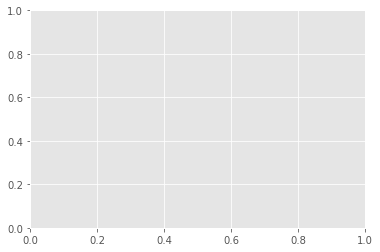

In [71]:
# Plotting the lat and lon as a scatterplot
obj = lg.plot_2d("B_lat_t", "B_lon_t", edges )


In [36]:
# Parameters for the map graph
kwds_basemap = {'llcrnrlon': graph.v.B_lon.min() - 40,
                'urcrnrlon': graph.v.B_lon.max() + 20,
                'llcrnrlat': graph.v.B_lat.min() - 20,
                'urcrnrlat': graph.v.B_lat.max() + 20,
                'resolution': 'i'}

kwds_scatter = {'s': 1, 
                'c': graph.v.B_id,
                'edgecolors':'none'}

/home/vnxiclaire/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/vnxiclaire/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/vnxiclaire/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3707: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/vnxiclaire/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3716: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


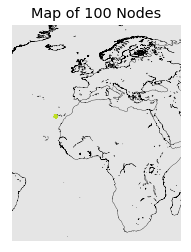

In [37]:
# Mapping the nodes
objs = graph.plot_map("B_lat", "B_lon",
                       edges = True,
                       kwds_basemap = kwds_basemap,
                       kwds_scatter = kwds_scatter)

objs['m'].drawcoastlines(linewidth=.3)
objs['ax'].set_title("Map of 100 Nodes")

I wanted to make a graph which each user to other users dependent on their nodes. In future exploration, I will be adding time into the analysis. Picking the users based on the when they started making a node and then calculating how far away they are from other users and how close they are in proximity of time.